## Tutorial on eQTL evaluation set 
This tutorial demonstrates how to take single-cell multiome (RNA + ATAC) data for SIMBA+  path score calculation and model training.

We'll use the PBMC multiome dataset with a more relevant cellular context.

In [31]:
import sys, os
sys.path.append(os.path.abspath("../src"))
import importlib
from simba_plus.discovery import candidate_links, build_evalset, add_features, model_training, plot_utils

importlib.reload(candidate_links)
importlib.reload(build_evalset)
importlib.reload(add_features)
importlib.reload(model_training)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import numpy as np
import pyranges as pr

os.makedirs("../data/reference", exist_ok=True)
os.makedirs("../data/validation", exist_ok=True)
os.makedirs("../data/results", exist_ok=True)


## 1️⃣ Candidate Link Generation
Reading TSS BED file and generating candidate peak–gene pairs from multiome data.


In [2]:
# --- For RNA (adata_CG) ---
adata_CG = ad.read_h5ad('/data/pinello/PROJECTS/2023_09_JF_SIMBAvariant/Fig3_link_prediction/data/multiome_10xpbmc10k_rna.h5ad')

# compute % of cells where gene is expressed
n_cells = (adata_CG.X >= 1).sum(axis=0).A1
adata_CG.var['n_cells'] = n_cells
adata_CG.var['pct_cells'] = n_cells/adata_CG.shape[0]

# filter genes expressed in >5% of cells
fivepct_genes = adata_CG.var_names[adata_CG.var["pct_cells"] > 0.05]

# --- For ATAC (adata_CP) ---
adata_CP = ad.read_h5ad('/data/pinello/PROJECTS/2023_09_JF_SIMBAvariant/Fig3_link_prediction/data/multiome_10xpbmc10k_atac.h5ad')

# compute % of cells where each peak is accessible
n_cells = (adata_CP.X >= 1).sum(axis=0).A1
adata_CP.var['n_cells'] = n_cells
adata_CP.var['pct_cells'] = n_cells/adata_CP.shape[0]

# filter peaks accessible in >5% of cells
fivepct_peaks = adata_CP.var_names[adata_CP.var["pct_cells"] > 0.05]

In [3]:
candidates = candidate_links.get_peak_gene_links(fivepct_peaks, fivepct_genes, cis_window=500000)
candidates.head()

Parsing peaks: 100%|██████████| 29427/29427 [00:00<00:00, 1022735.65it/s]


Finding TSS–peak overlaps...


,Gene_name,Gene_ID,Peak,Distance_to_TSS,TSS,peak_gene_pair
194,NOC2L,ENSG00000188976,chr1_777634_779926,180269,959049,chr1_777634_779926_NOC2L
195,NOC2L,ENSG00000188976,chr1_819912_823500,137343,959049,chr1_819912_823500_NOC2L
196,NOC2L,ENSG00000188976,chr1_826612_827979,131754,959049,chr1_826612_827979_NOC2L
197,NOC2L,ENSG00000188976,chr1_869449_870383,89133,959049,chr1_869449_870383_NOC2L
198,NOC2L,ENSG00000188976,chr1_903617_907386,53548,959049,chr1_903617_907386_NOC2L


## 2️⃣ eQTL Evaluation Set Construction
unlike in CRISPR eval set, which requires only one file, eQTL eval set construction requires 
- Download of 1) 1000 Genome Project Variants; 2) fine-mapped GTEx eQTLs; 3) GTF annotation file for gene symbol conversion
- Liftover for 1000 Genome Project Variants

Given the preprocessing complexity, I will break them into steps


## 2A Download files

In [12]:
build_evalset._download_and_extract_1000g(download_dir="../data/1000genome")

--2025-11-06 06:59:27--  https://zenodo.org/records/8292725/files/1000G_Phase3_plinkfiles.tgz?download=1
Resolving zenodo.org (zenodo.org)... 137.138.52.235, 188.185.43.153, 188.185.48.75, ...
Connecting to zenodo.org (zenodo.org)|137.138.52.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 288277344 (275M) [application/octet-stream]
Saving to: ‘/data/pinello/PROJECTS/2023_09_JF_SIMBAvariant/simba-plus/data/1000genome/1000G_EUR_Phase3_plink.tgz’

     0K .......... .......... .......... .......... ..........  0%  112K 41m42s
    50K .......... .......... .......... .......... ..........  0%  249K 30m17s
   100K .......... .......... .......... .......... ..........  0%  256K 26m17s
   150K .......... .......... .......... .......... ..........  0%  321K 23m21s
   200K .......... .......... .......... .......... ..........  0%  313K 21m40s
   250K .......... .......... .......... .......... ..........  0%  626K 19m18s
   300K .......... .......... .......... 

Extracting 1000G_EUR_Phase3_plink.tgz to /data/pinello/PROJECTS/2023_09_JF_SIMBAvariant/simba-plus/data/1000genome ...
Extracted: /data/pinello/PROJECTS/2023_09_JF_SIMBAvariant/simba-plus/data/1000genome/1000G_EUR_Phase3_plink


--2025-11-06 07:02:57--  https://zenodo.org/records/8292725/files/1000G_Phase3_frq.tgz?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.153, 188.185.48.75, 137.138.52.235, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85939688 (82M) [application/octet-stream]
Saving to: ‘/data/pinello/PROJECTS/2023_09_JF_SIMBAvariant/simba-plus/data/1000genome/1000G_Phase3_frq.tgz’

     0K .......... .......... .......... .......... ..........  0%  113K 12m24s
    50K .......... .......... .......... .......... ..........  0%  314K 8m25s
   100K .......... .......... .......... .......... ..........  0%  309K 7m7s
   150K .......... .......... .......... .......... ..........  0%  315K 6m26s
   200K .......... .......... .......... .......... ..........  0%  657K 5m34s
   250K .......... .......... .......... .......... ..........  0%  616K 5m1s
   300K .......... .......... .......... .......... .......... 

Extracting 1000G_Phase3_frq.tgz to /data/pinello/PROJECTS/2023_09_JF_SIMBAvariant/simba-plus/data/1000genome ...
Extracted: /data/pinello/PROJECTS/2023_09_JF_SIMBAvariant/simba-plus/data/1000genome/1000G_Phase3_frq
Both 1000G PLINK and FRQ archives are ready.


('/data/pinello/PROJECTS/2023_09_JF_SIMBAvariant/simba-plus/data/1000genome/1000G_EUR_Phase3_plink',
 '/data/pinello/PROJECTS/2023_09_JF_SIMBAvariant/simba-plus/data/1000genome/1000G_Phase3_frq')

In [11]:
build_evalset._download_and_extract_gtex(download_dir="../data/gtex")

--2025-11-06 06:54:57--  https://www.dropbox.com/scl/fo/bjp6o8hgixt5occ6ggq2o/ADTTMnyH-4rzDFS6g7oIcEE?rlkey=7558jp42yvmyjhgmcilbhlnu7&e=4&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbbe067da896c0be26dafc6c212.dl.dropboxusercontent.com/zip_download_get/CYC4jCMi026wtAj-5gPbw41UTu0nFYoz9znMih2BF4RdNfYXuUXVZIf0WPE0_xgaebRWLzPL69N82VZcHBfa9vVqV0is7VZNventjuEmu47oBw# [following]
--2025-11-06 06:54:58--  https://ucbbe067da896c0be26dafc6c212.dl.dropboxusercontent.com/zip_download_get/CYC4jCMi026wtAj-5gPbw41UTu0nFYoz9znMih2BF4RdNfYXuUXVZIf0WPE0_xgaebRWLzPL69N82VZcHBfa9vVqV0is7VZNventjuEmu47oBw
Resolving ucbbe067da896c0be26dafc6c212.dl.dropboxusercontent.com (ucbbe067da896c0be26dafc6c212.dl.dropboxusercontent.com)... 162.125.4.15, 2620:100:6019:15::a27d:40f
Connecting to ucbbe067da896c0be26dafc6c212.

Extracting /data/pinello/PROJECTS/2023_09_JF_SIMBAvariant/simba-plus/data/gtex/Public_GTEx_finemapping.zip ...
Extracted GTEx data to: /data/pinello/PROJECTS/2023_09_JF_SIMBAvariant/simba-plus/data/gtex
GTEx fine-mapping data ready: /data/pinello/PROJECTS/2023_09_JF_SIMBAvariant/simba-plus/data/gtex/GTEx_49tissues_release1.tsv.bgz


'/data/pinello/PROJECTS/2023_09_JF_SIMBAvariant/simba-plus/data/gtex/GTEx_49tissues_release1.tsv.bgz'

In [27]:
build_evalset._download_liftover_resources(download_dir="../data/liftover_resources")

liftOver binary saved to: ../data/liftover_resources/liftOver
Chain file saved to: ../data/liftover_resources/hg19ToHg38.over.chain.gz


('../data/liftover_resources/liftOver',
 '../data/liftover_resources/hg19ToHg38.over.chain.gz')

## 2B Process files

In [2]:
bed_files = build_evalset._process_1000g_bim_frq(plink_dir='../data/1000genome/1000G_EUR_Phase3_plink', 
                                     frq_dir='../data/1000genome/1000G_Phase3_frq', 
                                     maf_threshold=0.01)

valid_chroms = [f"chr{i}" for i in range(1, 23)]
genomes_df = (
    pd.concat(
        [pd.read_csv(f, sep="\t", header=None, names=["CHROM", "START", "END"]) for f in bed_files],
        ignore_index=True
    )
    .assign(CHROM=lambda d: "chr" + d["CHROM"].astype(str))
    .loc[lambda d: d["CHROM"].isin(valid_chroms)]
) # 1000G variants in BED format

Found existing 1000G filtered BED files — skipping regeneration.


In [3]:
## liftOver 1000G variants to hg38
CHAIN_FILE = "../data/liftover_resources/hg19ToHg38.over.chain.gz"

# ideally use the downloaded binary, but it fails on ml008 due to linux system incompatability, 
# so for demonstration I use my previously downloaded version
# LIFTOVER_BIN = "../data/liftover_resources/liftOver" # downloaded version
LIFTOVER_BIN = "/data/pinello/PROJECTS/2023_09_JF_SIMBAvariant/Fig4_onek1k/Fig4_data/liftOver"
OUT_DIR = "../data/liftover"

lifted_df = build_evalset.liftover_df(genomes_df, CHAIN_FILE, LIFTOVER_BIN, out_dir=OUT_DIR, prefix="example")
lifted_df = lifted_df[lifted_df['CHROM'].isin(valid_chroms)] # remove alternate contigs, scaffolds, etc., keep only chr1-22

variants_bed = pr.PyRanges(
    lifted_df.rename(columns={"CHROM": "Chromosome", "START": "Start", "END": "End"})
) # convert to PyRanges object ready for later overlap operations with peaks

Running: /data/pinello/PROJECTS/2023_09_JF_SIMBAvariant/Fig4_onek1k/Fig4_data/liftOver ../data/liftover/example.bed ../data/liftover_resources/hg19ToHg38.over.chain.gz ../data/liftover/example_lifted.bed ../data/liftover/example_unmapped.bed


Reading liftover chains
Mapping coordinates


Liftover completed! 8,563,303 regions mapped successfully.


In [4]:
# now process GTEx data
gtex_df = build_evalset.load_gtex_finemap(
    "../data/gtex/GTEx_49tissues_release1.tsv.bgz",
    tissue="Whole_Blood",
    method="SUSIE"
)

# define positive / negative training sets
pos_training = gtex_df[gtex_df["pip"] > 0.5].drop_duplicates("pair")
neg_training = gtex_df[gtex_df["pip"] < 0.01].drop_duplicates("pair")


Loading GTEx fine-mapping data from: ../data/gtex/GTEx_49tissues_release1.tsv.bgz
Filtered for SUSIE in Whole_Blood: 381,828 entries
Found existing GTF file — skipping download.
Added GeneSymbol for 379179 of 381828 genes.
🔠 Added GeneSymbol for 379,179 genes
Final GTEx dataset ready with 379,179 SNP–gene pairs


## 2C Finally...let's overlap variants with peaks!

In [8]:
candidates = pd.read_csv("../data/validation/eqtl_candidates.csv")
overlap_df = build_evalset.overlap_variants_with_peaks(candidates, variants_bed) # overlap 1000G variants with peaks
final_df = build_evalset.merge_and_label_eqtl_pairs(candidates, overlap_df, pos_training, neg_training) # label positive / negative pairs based on GTEx PIP score


Found 1,859,851 overlapping variant–peak records.
total 6205 pairs.


## 3️⃣ Add SIMBA+ Path Score

In [28]:
eqtl_eval_df = final_df.copy()

In [32]:
# === Paths to SIMBA+ embeddings ===
adata_C_path = "/data/pinello/PROJECTS/2023_09_JF_SIMBAvariant/Fig3_link_prediction/data/embeddings/simbaplus_pbmc_adata_C.h5ad"
adata_G_path = "/data/pinello/PROJECTS/2023_09_JF_SIMBAvariant/Fig3_link_prediction/data/embeddings/simbaplus_pbmc_adata_G.h5ad"
adata_P_path = "/data/pinello/PROJECTS/2023_09_JF_SIMBAvariant/Fig3_link_prediction/data/embeddings/simbaplus_pbmc_adata_P.h5ad"

# === Run feature addition ===
eqtl_eval_with_features = add_features.add_simba_plus_features(
    eval_df=eqtl_eval_df,
    adata_C_path=adata_C_path,
    adata_G_path=adata_G_path,
    adata_P_path=adata_P_path,
    gene_col="Gene",
    peak_col="Peak",
)

/data/pinello/PROJECTS/2023_09_JF_SIMBAvariant/simba-plus/src/simba_plus/discovery/add_features.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_df["gidx"] = split_df["Gene"].map(lambda g: adata_G.obs.index.values.tolist().index(g))
/data/pinello/PROJECTS/2023_09_JF_SIMBAvariant/simba-plus/src/simba_plus/discovery/add_features.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_df["pidx"] = split_df["Peak"].map(lambda p: adata_P.obs.index.get_loc(p))


Computing global SIMBA+ path scores...


## 4️⃣ Model training
in manuscript, model is trained 5 times with different random seeds: seeds = [1, 2, 3, 4, 5] and n_search_iter=60 prediction prob averaged across 5 runs for final visualization

In [34]:
feature_sets = {
    "simba_plus_distance": ["SIMBA+_path_score", "1/Distance"],
    "distance_only": ["1/Distance"],
    "simba_plus_only": ["SIMBA+_path_score"],
}

results = model_training.train_xgboost(
        df=eqtl_eval_with_features,
        dataset_name="eqtl",
        output_dir="../results/xgb_models",
        feature_sets=feature_sets,
        n_search_iter=30,
        search_n_jobs=8,
        random_state=1
    )


Preprocessing dataset 'eqtl'...
Starting training for 3 model(s)...

=== Training model: simba_plus_distance ===
[LOCO] Holding out chr1 for validation
  ↳ Best params: {'subsample': 1.0, 'scale_pos_weight': 4.379421221864952, 'reg_lambda': 3, 'reg_alpha': 3, 'random_state': 1, 'n_jobs': 1, 'n_estimators': 6000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.02, 'gamma': 1.5, 'colsample_bytree': 0.6}
[LOCO] Holding out chr10 for validation
  ↳ Best params: {'subsample': 1.0, 'scale_pos_weight': 4.379421221864952, 'reg_lambda': 3, 'reg_alpha': 3, 'random_state': 1, 'n_jobs': 1, 'n_estimators': 6000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.02, 'gamma': 1.5, 'colsample_bytree': 0.6}
[LOCO] Holding out chr11 for validation
  ↳ Best params: {'subsample': 1.0, 'scale_pos_weight': 4.379421221864952, 'reg_lambda': 3, 'reg_alpha': 0, 'random_state': 1, 'n_jobs': 1, 'n_estimators': 3000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.05, 'gamma': 2, 'colsa

In [35]:
# quickly load results if needed
from simba_plus.discovery.model_training import load_results

results_obj, metrics_df, preds_df = load_results(
    "../results/xgb_models"
)

## 5️⃣ Plotting

In [36]:
# Customizable labels and columns
columns_and_labels = [
    ('SIMBA+ path score + 1/Distance', 'pred_prob_simba_plus_distance'),
    ('SIMBA+ path score only', 'pred_prob_simba_plus_only'),
    ('1/Distance', 'pred_prob_distance_only'),
]

Saved figure → ../results/crispr_supervised.pdf


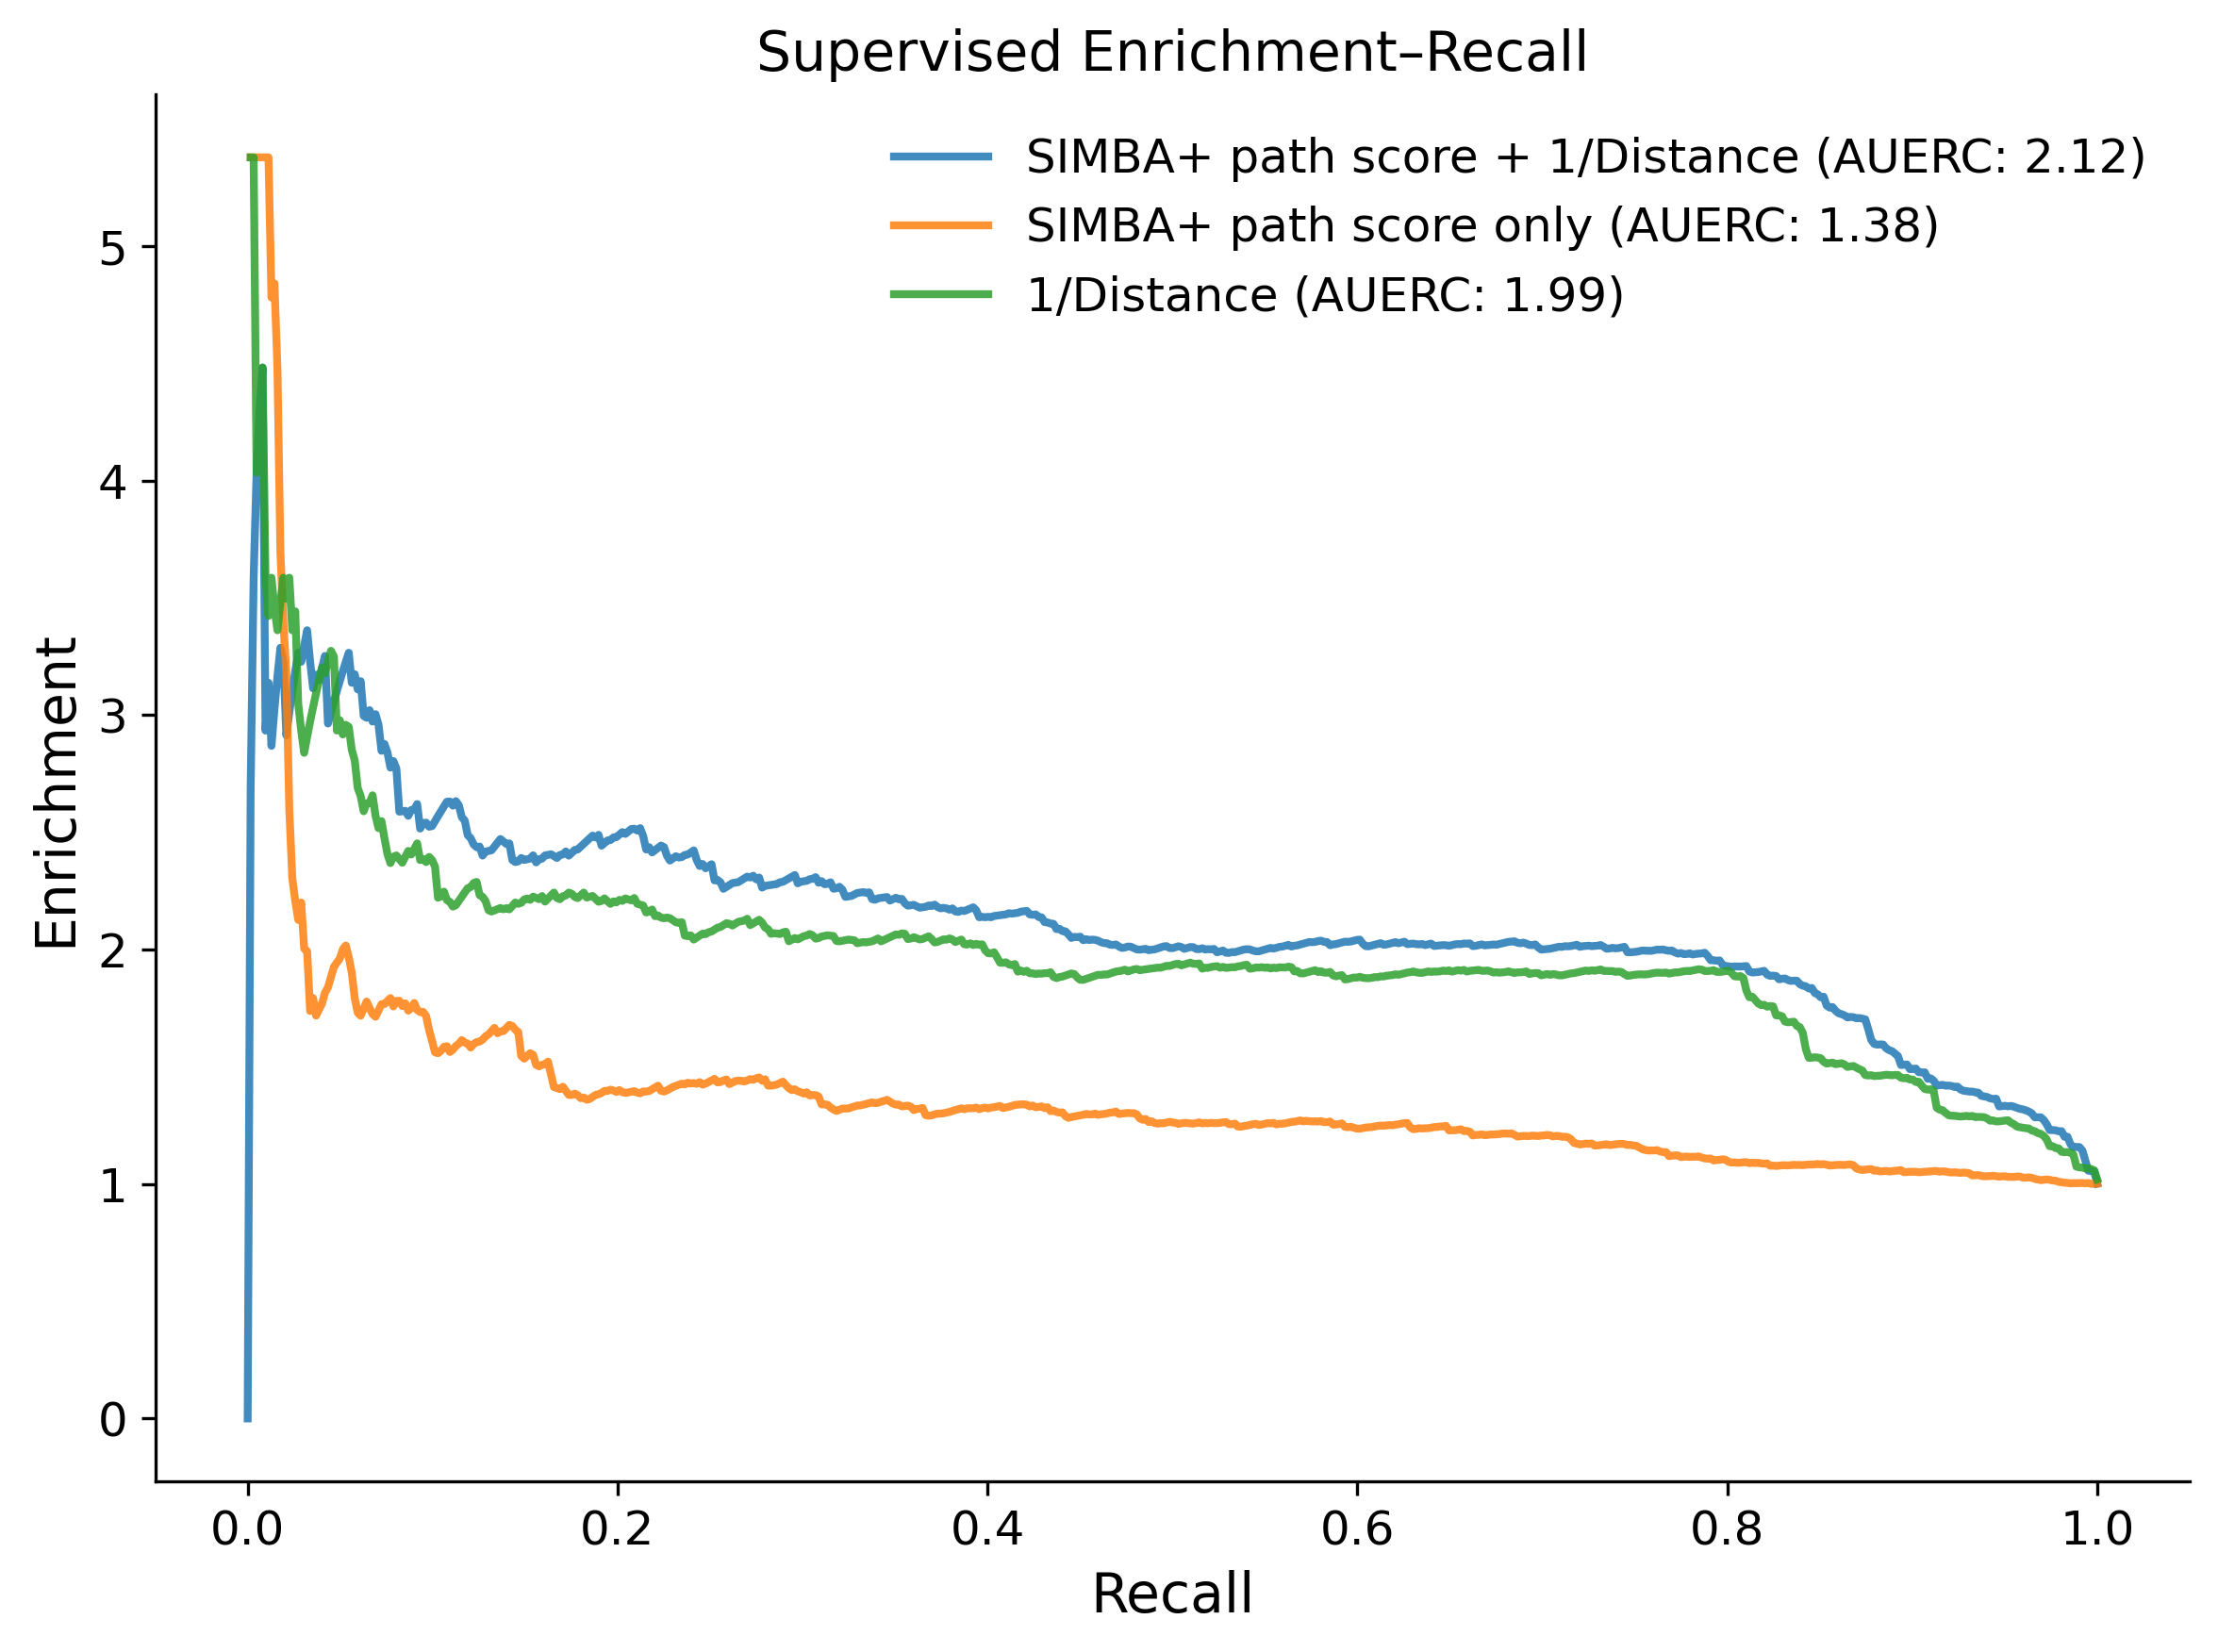

In [ ]:
# --- Supervised plot ---
preds_df.rename(columns={'true_label':'gold'}, inplace=True)
plot_utils.plot_supervised(
    preds_df,
    columns_and_labels=columns_and_labels,
    save_path="../results/eqtl_supervised.pdf"
)

Saved figure → ../results/eqtl_unsupervised.pdf


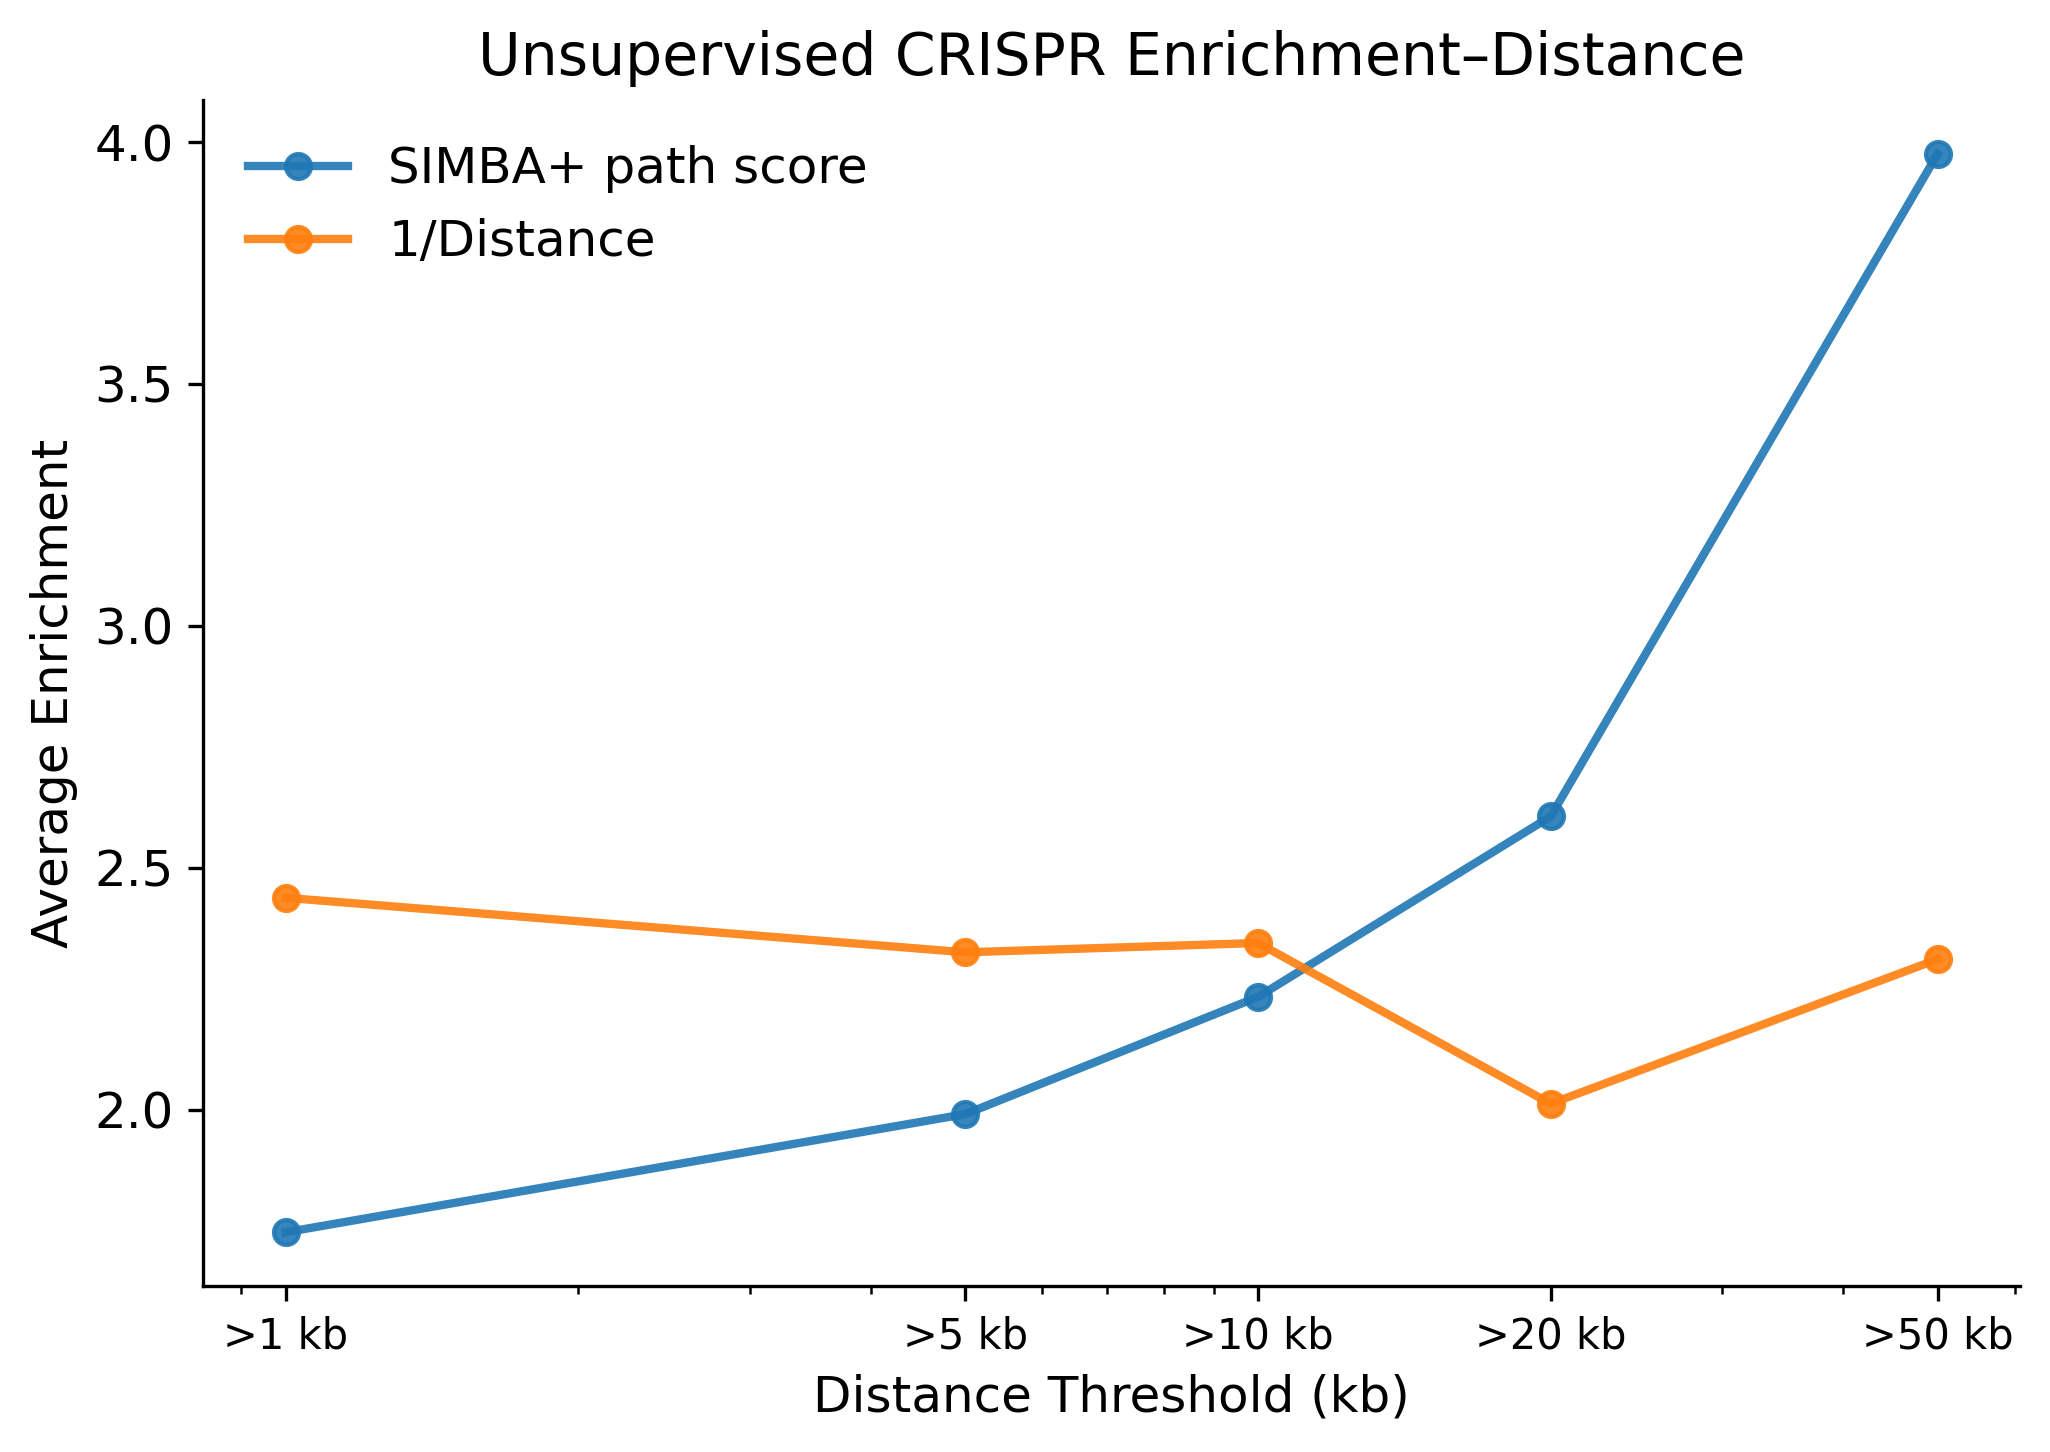

In [38]:
# Unsupervised distance plot
thresholds = [1000, 5000, 10000, 20000, 50000]
datasets = [eqtl_eval_with_features]
dataset_names = ['eqtl']
columns_and_labels=[
        ('SIMBA+ path score', 'SIMBA+_path_score'),
        ('1/Distance', '1/Distance'),
    ]

# add gold column
eqtl_eval_with_features['gold'] = eqtl_eval_with_features['label']
plot_utils.plot_unsupervised(
    eqtl_eval_with_features, columns_and_labels,
    thresholds, save_fig=True, save_path="../results/eqtl_unsupervised.pdf"
)
